# MVP-Analise Exploratória - PUC-Rio
Aluno: Tales Gonçalves

# Objetivo:

Esta análise visa compreender os dados armazenados no aplicativo Strava que contém informações sobre as minhas atividades de ciclismo, corrida, musculação, entre outras e que são coletadas durante o uso de aparelho celular ou smart watch.

O objetivo será prever a frequência cardíaca média utilizando os atributos selecionados no dataset e treinar modelos clássicos de marchine learning utilizando métodos não supervisionados com a regressão linear.

Para conhecimento de mais detalhes sobre o aplicativo Strava acesse www.strava.com, meu perfil https://www.strava.com/athletes/11601498.

## 1.1 Carga e Preparação dos dados

Carregamento das principais bibliotecas python para processamento de dados.

In [2]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import missingno as ms # para tratamento de missings
from datetime import datetime, timedelta
from sklearn.datasets import load_wine # para importar o dataset wine
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score # para a exibição da acurácia do modelo
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import(model_selection,preprocessing,)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from yellowbrick.features.pca import PCADecomposition
from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
import pydotplus
from io import StringIO
from IPython.display import Image
import matplotlib.pyplot as plt
import dtreeviz
import xgboost as xgb
from seaborn import heatmap

### 1.1.1 Leitura dataset
Leitura de arquivo json que esta no repositório do Github

In [3]:
# lendo arquivo json e visualizando as 10 primeiras linhas
df = pd.read_json('https://raw.githubusercontent.com/tal-rsg/mvp-analise/main/activities_data.json')

# verificando se é um dataframe
type(df)

pandas.core.frame.DataFrame

In [4]:
df.columns

Index(['resource_state', 'athlete', 'name', 'distance', 'moving_time',
       'elapsed_time', 'total_elevation_gain', 'type', 'sport_type', 'id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'map', 'trainer', 'commute', 'manual', 'private',
       'visibility', 'flagged', 'gear_id', 'start_latlng', 'end_latlng',
       'average_speed', 'max_speed', 'average_watts', 'kilojoules',
       'device_watts', 'has_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'workout_type', 'average_heartrate',
       'max_heartrate', 'average_temp', 'average_cadence'],
      dtype='object')

### 1.1.2 Limpeza
Devido a extenção de atributos no dataset selecionamos os principais que compreendemos serem os mais úteis para continuarmos e realizamos a limpeza dos valores nulos.

In [5]:
# criando um novo dataframe com a seleção de alguns atributos
df_strava = df.loc[(df['sport_type'] == "Ride") & (df['distance'] >= 10000),['distance','moving_time','total_elevation_gain','start_date','average_speed','max_speed','average_heartrate','max_heartrate', 'elev_high', 'elev_low','average_temp']]

df_strava.head()

,distance,moving_time,total_elevation_gain,start_date,average_speed,max_speed,average_heartrate,max_heartrate,elev_high,elev_low,average_temp
1,21101.3,6345,546.2,2024-04-07T11:19:35Z,3.326,11.460,143.3,205.0,598.3,274.3,NaN
2,59764.2,11776,779.3,2024-04-06T11:13:37Z,5.075,14.545,148.3,177.0,575.1,277.4,NaN
3,35162.6,6060,616.3,2024-04-03T10:34:20Z,5.802,12.472,147.9,181.0,506.1,277.1,NaN
4,19566.0,3826,367.3,2024-04-02T10:45:59Z,5.114,12.807,152.0,191.0,520.1,273.8,NaN
6,19546.4,4244,373.9,2024-03-19T10:46:01Z,4.606,12.215,147.8,182.0,525.2,275.0,NaN


Text(0.5, 1.0, 'Verificando se há valores nulos')

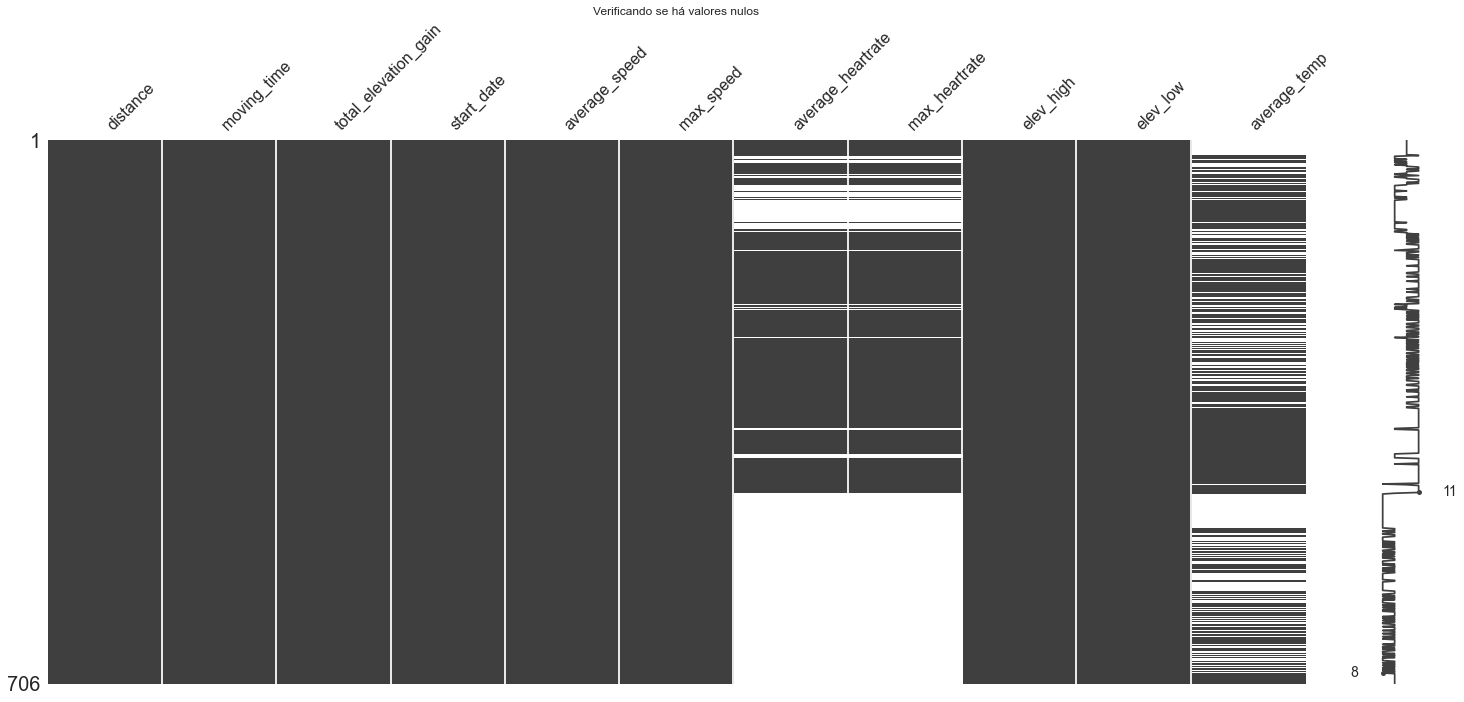

In [6]:
# exibindo visualização matricial da nulidade do dataset
ms.matrix(df_strava)
plt.title('Verificando se há valores nulos')

Tratando os valores nulos do dataset

Text(0.5, 1.0, 'Visulizando se há valores nulos')

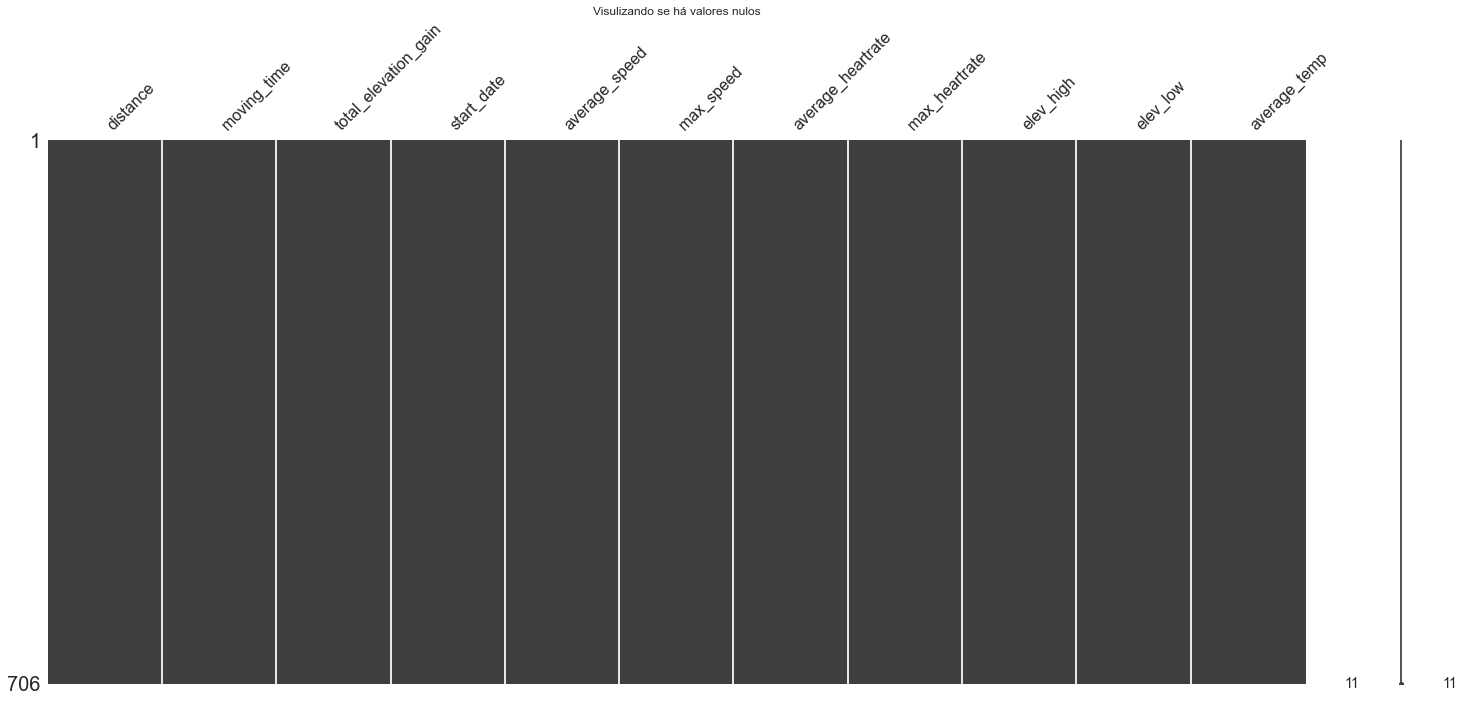

In [7]:
# substituindo os NaN de 'average_heartrate', 'max_heartrate' e 'average_temp' pela mediana da coluna
df_strava['average_heartrate'].fillna(df_strava['average_heartrate'].median(), inplace=True)
df_strava['max_heartrate'].fillna(df_strava['max_heartrate'].median(), inplace=True)
df_strava['average_temp'].fillna(df_strava['average_temp'].median(), inplace=True)

# visualizando se ha valores nulos
ms.matrix(df_strava)
plt.title('Visulizando se há valores nulos')

Inserindo novos atributos como a idade (Age) no periodo da atividade e a frequência cardíaca máxima (FCmax) com base nos existente para melhor análise dos dados.

In [102]:
# convertendo o campo start_date para o tipo data
df_strava['start_date'] = pd.to_datetime(df_strava['start_date'])

# funcao para calcular a idade no periodo da atividade
def calculate_age(birthdate):
    current_date = datetime(1980,11,18)
    age = birthdate.year - current_date.year - ((current_date.month, current_date.day) < (birthdate.month, birthdate.day))
    return age

# criando a nova coluna com o calculo da idade no periodo da atividade
df_strava['Age'] = df_strava['start_date'].apply(calculate_age)

# função para calcular o Frequencia Cardiaca Maxima (FC max)
def calc_fcmax(fcmax):
    fc_max = 220 - fcmax
    return fc_max

# criando a nova coluna com o calculo do FC Max com base na coluna idade
df_strava['FCmax'] = df_strava['Age'].apply(calc_fcmax)

# visualizando o dataframe
df_strava.head()

,distance,moving_time,total_elevation_gain,start_date,average_speed,max_speed,average_heartrate,max_heartrate,elev_high,elev_low,average_temp,Age,FCmax
62,18394.9,5827,561.0,2023-05-21 12:29:53+00:00,3.157,9.772,NaN,NaN,473.4,205.2,28.0,43,177
63,21962.0,5366,563.0,2023-05-20 11:53:10+00:00,4.093,12.454,NaN,NaN,470.4,189.4,21.0,43,177
64,32064.5,8182,564.0,2023-05-13 11:47:03+00:00,3.919,11.872,NaN,NaN,505.0,258.0,24.0,43,177
65,17992.0,6091,514.0,2023-05-07 11:15:08+00:00,2.954,10.422,NaN,NaN,538.6,211.8,27.0,43,177
67,17715.4,6043,502.0,2023-05-01 11:54:00+00:00,2.932,11.298,NaN,NaN,483.6,225.8,29.0,43,177


Neste ponto será criado o alvo (target) com base no atributo 'average_heartrate' (média de batimentos) para as análises seguinte.

In [9]:
df_lrstravatrain = df_strava.loc[:,['distance','moving_time','total_elevation_gain','average_speed','max_speed','elev_high', 'elev_low','average_temp', 'Age', 'FCmax']]

df_lrstravatrain['target'] = df_strava['average_heartrate']

df_lrstravatrain.head()

,distance,moving_time,total_elevation_gain,average_speed,max_speed,elev_high,elev_low,average_temp,Age,FCmax,target
1,21101.3,6345,546.2,3.326,11.460,598.3,274.3,26.0,44,176,143.3
2,59764.2,11776,779.3,5.075,14.545,575.1,277.4,26.0,44,176,148.3
3,35162.6,6060,616.3,5.802,12.472,506.1,277.1,26.0,44,176,147.9
4,19566.0,3826,367.3,5.114,12.807,520.1,273.8,26.0,44,176,152.0
6,19546.4,4244,373.9,4.606,12.215,525.2,275.0,26.0,44,176,147.8


Visualizando a correlação dos atributos.

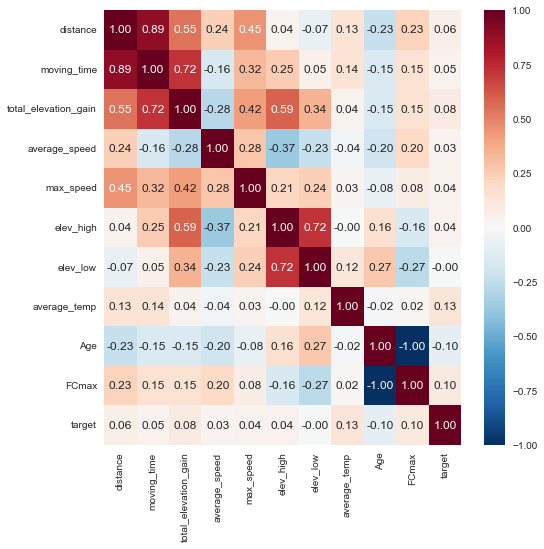

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
ax = heatmap(
    df_lrstravatrain.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,

)

## 1.2 Modelagem
Nesta etapa será realizado uma exploração e preparação dos dados para chegar ha um modelo que atenda os requisitos de desempenho e precisão.

### 1.2.1 Separação da base
Apartir deste ponto a base é separada em bases de treino e testes

In [11]:
# Separação em bases de treino e teste (holdout)
array = df_lrstravatrain.values
lr_X = array[:,0:10] # atributos
lr_y = array[:,10] # classe (target)

lrX_train, lrX_test, lry_train, lry_test = train_test_split(lr_X, lr_y, test_size=0.3, random_state=42) # faz a divisão

# criando so folds
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

### 1.2.2. Avaliando os modelos
Realizando a comparação dos modelos para uma melhor escolha

LR: MSE -31.17 (12.31) - RMSE 5.58
Ridge: MSE -31.17 (12.31) - RMSE 5.58
Lasso: MSE -31.45 (12.50) - RMSE 5.61
KNN: MSE -39.29 (12.95) - RMSE 6.27
CART: MSE -62.78 (21.78) - RMSE 7.92
SVR: MSE -31.65 (12.58) - RMSE 5.63


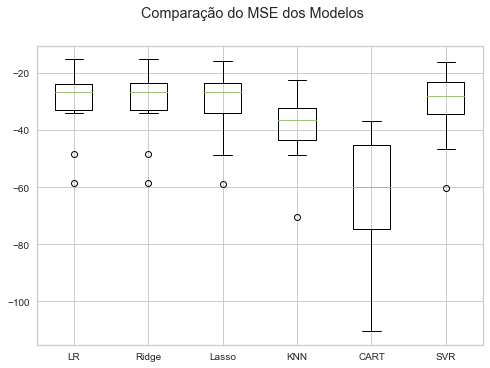

In [12]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(10) 

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, lrX_train, lry_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2F" % (name, cv_results.mean(), cv_results.std(), np.sqrt(abs(cv_results.mean()))) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure() 
fig.suptitle('Comparação do MSE dos Modelos') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

No gráfico acima é possível verificar que o modelos indicados são a regressão linear, Ridge e Lasso e que serão explorados a seguir


### 1.2.3 Métrica de avaliação
Verificando as métricas  para o modelo de Regressão Linear

In [13]:
# Assuming X_train, X_test, y_train, y_test are your training and test sets
X_train, X_test, y_train, y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False to get RMSE directly
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 42.49513615465875
Root Mean Squared Error (RMSE): 6.518829354620257
Mean Absolute Error (MAE): 3.989239907487328
R-squared (R²): 0.03630420775521559


É possível observar que o modelo apresenta um bom desempenho para atingir a meta desejada.

### 1.2.4 Avalidando modelos com dados originais, padronizados e normalizados

LR-orig: -31.417 (10.638)
KNN-orig: -37.880 (11.414)
CART-orig: -65.391 (18.614)
SVR-orig: -32.035 (11.478)
LR-padr: -32.768 (13.978)
KNN-padr: -33.624 (7.360)
CART-padr: -64.182 (19.350)
SVR-padr: -30.698 (10.883)
LR-norm: -31.306 (10.623)
KNN-norm: -33.855 (12.651)
CART-norm: -62.591 (17.969)
SVR-norm: -31.150 (11.021)


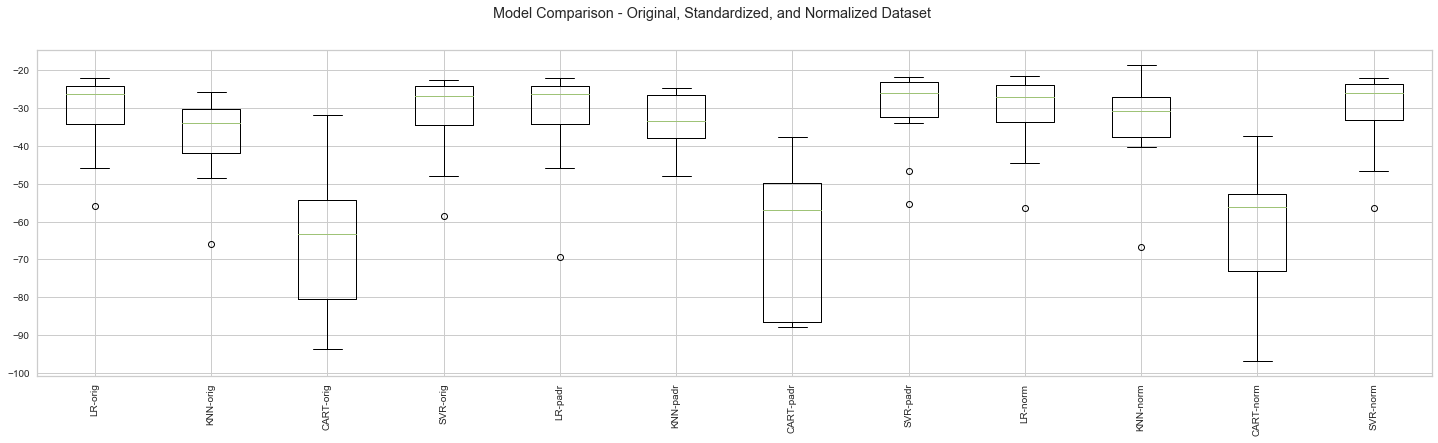

In [14]:
# Defining a global seed for this block
np.random.seed(7)

# Lists to store pipelines and results for all dataset views
pipelines = []
results = []
names = []

# Defining base classifier parameters for the BaggingClassifier
base_classifier = DecisionTreeRegressor()
num_trees = 100
max_features = 3

# Creating the pipeline elements

# Algorithms to be used
reg_log = ('LR', LinearRegression())
knn = ('KNN', KNeighborsRegressor())
cart = ('CART', DecisionTreeRegressor())
svr = ('SVR', SVR())
#random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))

# Transformations to be used
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Building the pipelines

# Original dataset
pipelines.append(('LR-orig', Pipeline([reg_log]))) 
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVR-orig', Pipeline([svr])))
#pipelines.append(('RF-orig', Pipeline([random_forest])))

# Standardized dataset
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log]))) 
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVR-padr', Pipeline([standard_scaler, svr])))
#pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))

# Normalized dataset
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log]))) 
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVR-norm', Pipeline([min_max_scaler, svr])))
#pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))

# Executing the pipelines
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
scoring = 'neg_mean_squared_error'

for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatting to 3 decimal places
    print(msg)

# Boxplot comparing the models
fig = plt.figure(figsize=(25,6))
fig.suptitle('Model Comparison - Original, Standardized, and Normalized Dataset') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names, rotation=90)
plt.show()

### Regressão

In [168]:
lr_sX = preprocessing.StandardScaler().fit_transform(lr_X)
sX_train, sX_test, sy_train, sy_test = model_selection.train_test_split(lr_sX, lr_y, test_size=0.5, random_state=36)

In [169]:
dr = DummyRegressor()
dr.fit(lrX_train, lry_train)
dr.score(lrX_test, lry_test)

-0.0001384024972834741

In [170]:
lr = LinearRegression()
lr.fit(lrX_train, lry_train)

LinearRegression()

In [18]:
lr.score(lrX_test, lry_test)

0.02135534722581256

In [19]:
lr.coef_

array([-2.73737478e-05,  3.22661509e-05,  2.02724874e-03,  5.45288367e-01,
       -8.87641984e-02,  2.61007407e-03, -3.19806392e-03,  2.53191533e-01,
       -9.04953940e-02,  9.04953940e-02])

In [20]:
lr2 = LinearRegression()
lr2.fit(sX_train, sy_train)

LinearRegression()

In [21]:
lr2.score(sX_test, sy_test)

0.02135534722581267

In [22]:
lr2.intercept_

151.8983770727291

In [23]:
lr2.coef_

array([-0.52270062,  0.10708379,  0.6703687 ,  0.85982175, -0.2388686 ,
        0.51216506, -0.3474265 ,  0.86667735, -0.22055624,  0.22055624])

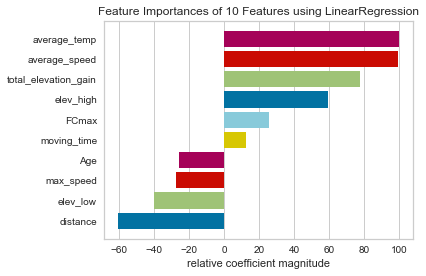

<AxesSubplot:title={'center':'Feature Importances of 10 Features using LinearRegression'}, xlabel='relative coefficient magnitude'>

In [24]:
fig, ax = plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(lr2, labels=df_lrstravatrain.columns)
fi_viz.fit(lr_X, lr_y)
fi_viz.poof()

### SVMs

In [25]:
svr = SVR()
svr.fit(sX_train, sy_train)

SVR()

In [26]:
svr.score(sX_test, sy_test)

0.06718880804318994

### K vizinhos mais próximos

In [27]:
knr = KNeighborsRegressor()
knr.fit(sX_train, sy_train)

KNeighborsRegressor()

In [28]:
knr.score(sX_test, sy_test)

0.08021802350851548

### Árvore de decisão

In [29]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(lrX_train, lry_train)

DecisionTreeRegressor(random_state=42)

In [30]:
dtr.score(lrX_test, lry_test)

-0.5862595673653128

In [31]:
df_lrstravatrain.columns

Index(['distance', 'moving_time', 'total_elevation_gain', 'average_speed',
       'max_speed', 'elev_high', 'elev_low', 'average_temp', 'Age', 'FCmax',
       'target'],
      dtype='object')

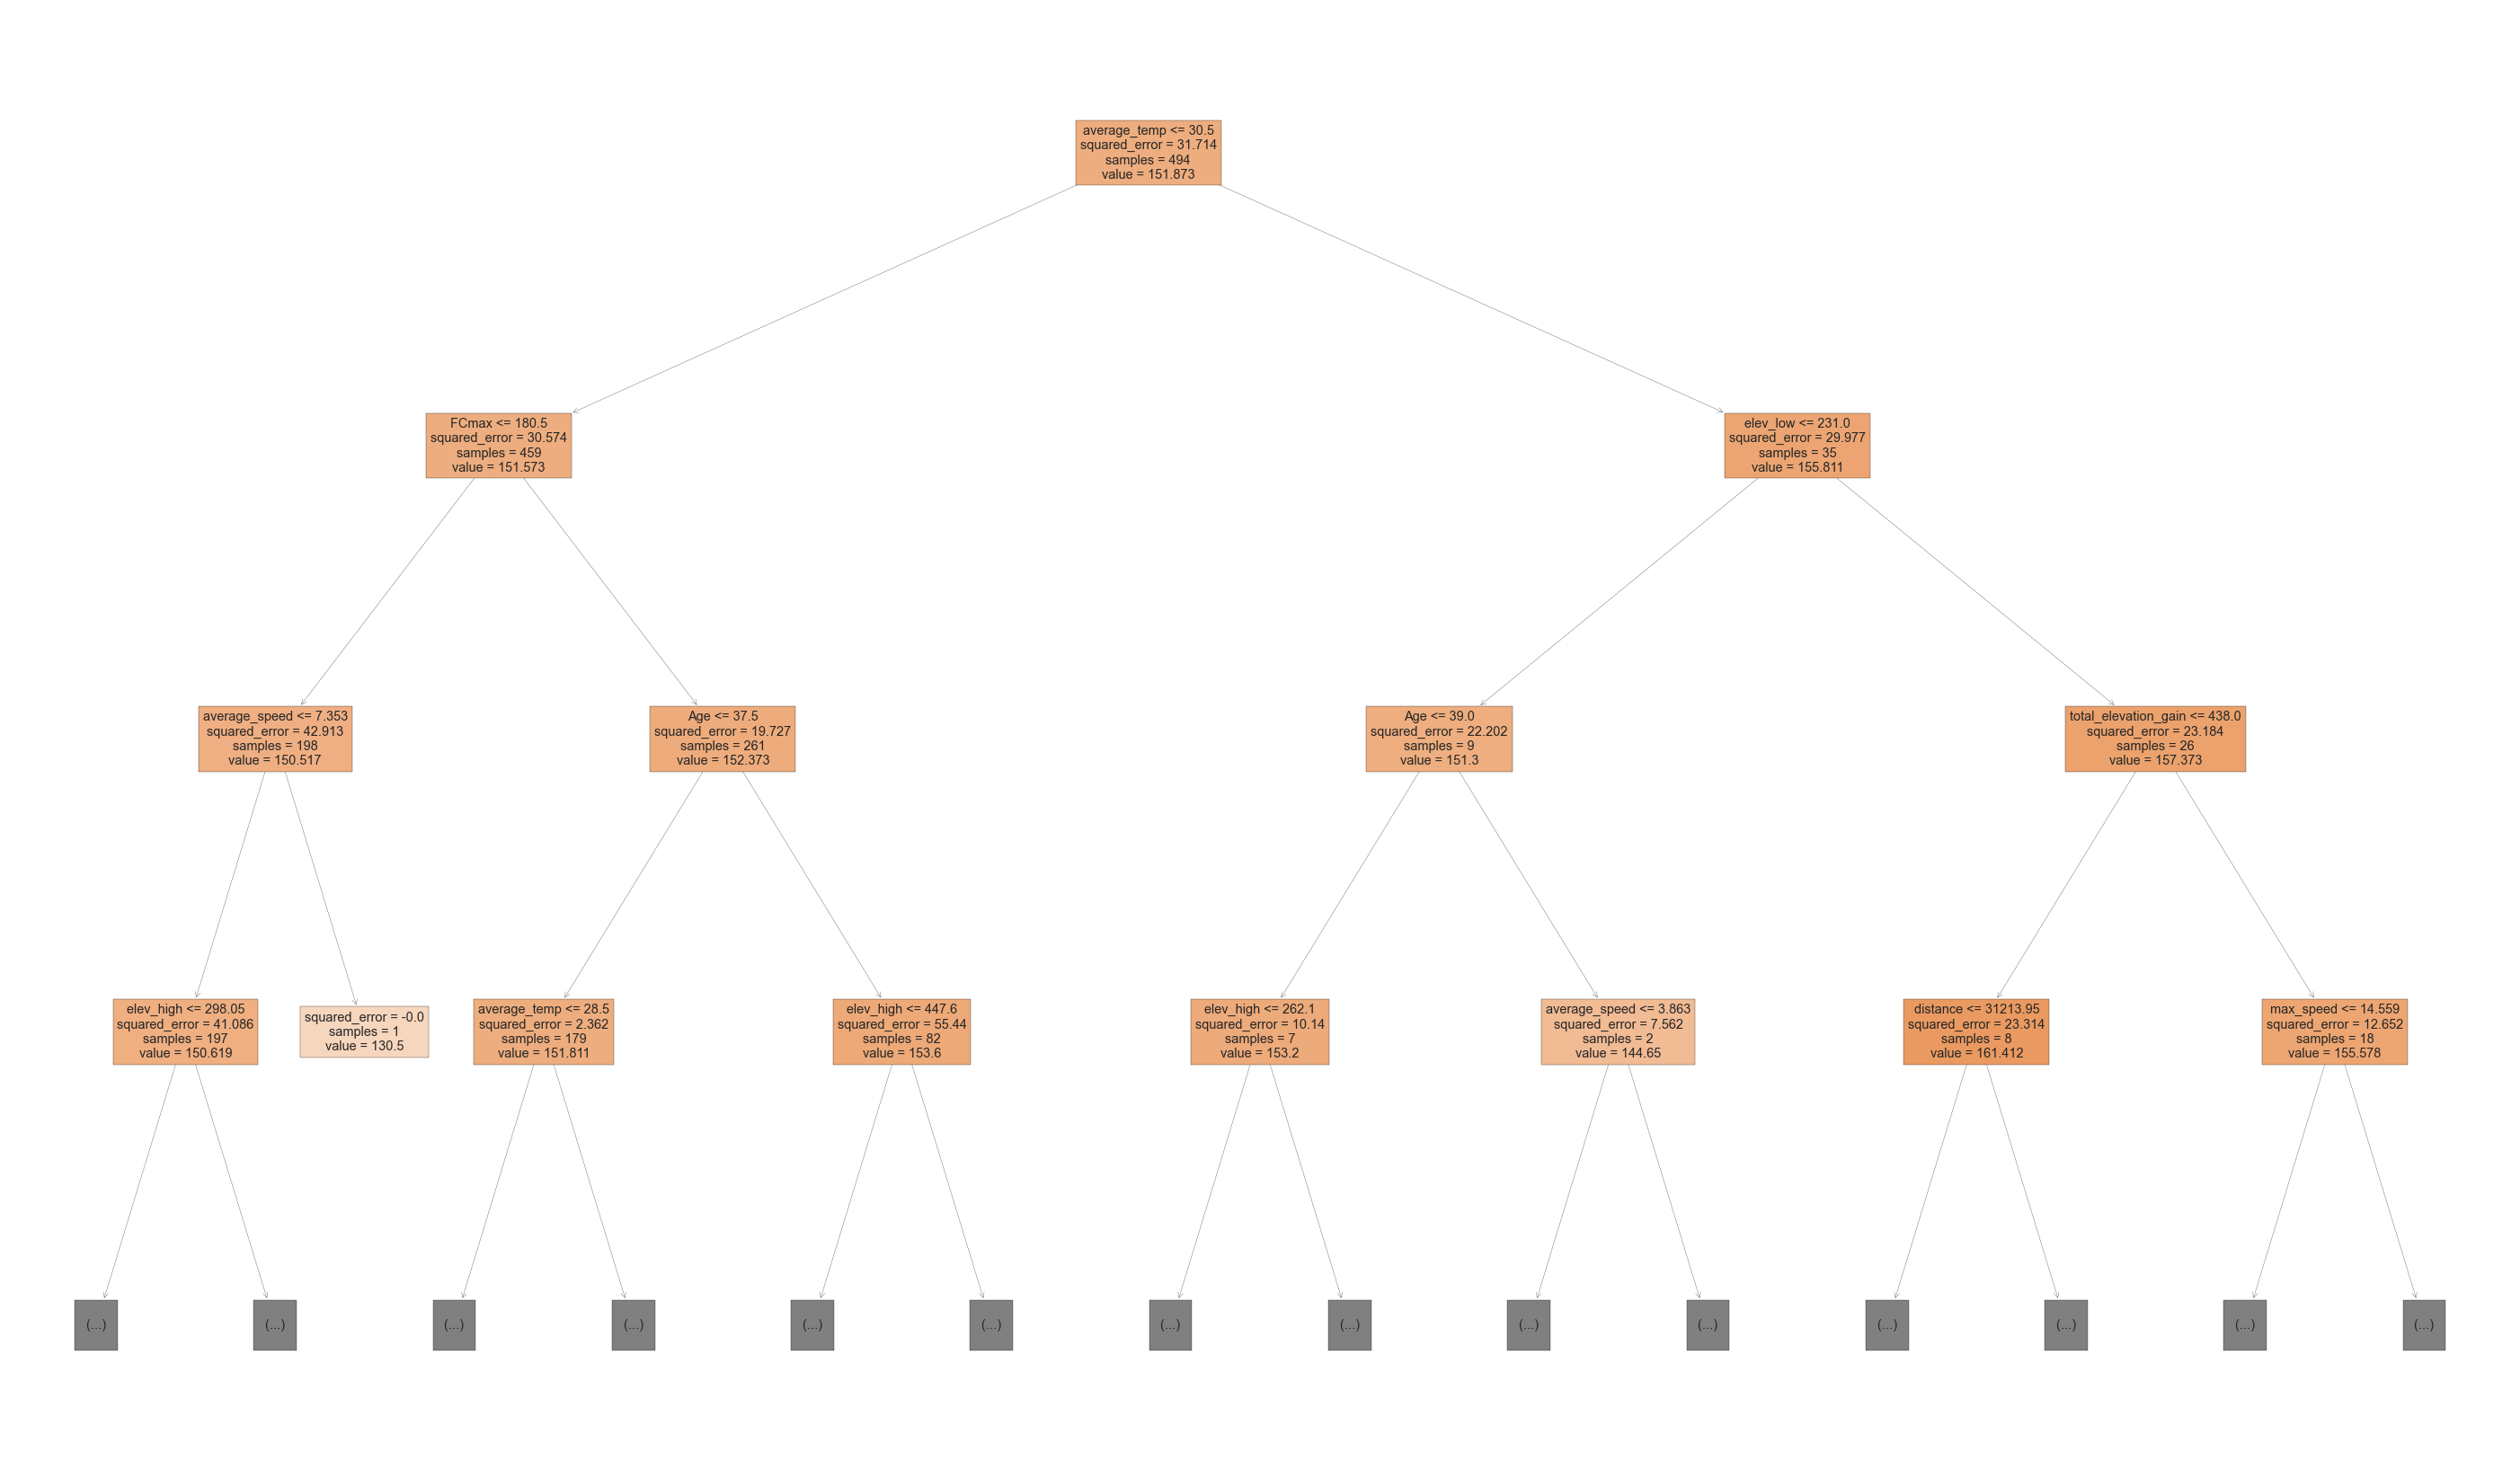

In [32]:
# Plot the CART model
plt.figure(figsize=(50, 30))
plot_tree(dtr, max_depth=3, filled=True, feature_names=df_lrstravatrain.columns, class_names=[str(x) for x in df_lrstravatrain['target'].unique()]) #df_lrstravatrain['target'].astype(str))
plt.show()

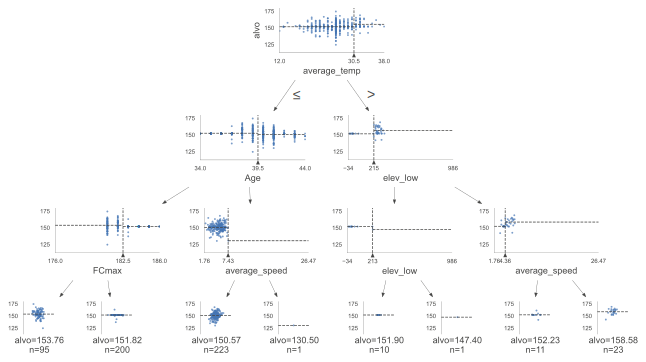

In [33]:
import dtreeviz.trees

arraylr = df_lrstravatrain.values

dc_X = array[:,0:10] # atributos
dc_y = array[:,10] # classe (target)

dcX_train, dcX_test, dcy_train, dcy_test = train_test_split(dc_X, dc_y, test_size=0.2, random_state=42)

dtr3 = DecisionTreeRegressor(max_depth=3)
dtr3.fit(dcX_train, dcy_train)
viz = dtreeviz.model(
    dtr3,
    dcX_train,
    dcy_train,
    target_name="alvo",
    feature_names=df_lrstravatrain.columns,
)
viz.view()

In [34]:
# importancia dos atributos

for col, val in sorted(
    zip(
        df_lrstravatrain.columns, dtr.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

elev_low       0.197
elev_high      0.168
average_speed     0.144
distance       0.126
max_speed      0.091


In [35]:
# floresta aleatória

rfr = RandomForestRegressor(
    random_state=42, n_estimators=100
)
rfr.fit(lrX_train, lry_train)

RandomForestRegressor(random_state=42)

In [36]:
rfr.score(lrX_test, lry_test)

0.025178963971857038

In [37]:
# importancia dos atritubos da árvore
for col, val in sorted(
    zip(
        df_lrstravatrain.columns, rfr.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

elev_low       0.144
elev_high      0.140
max_speed      0.134
average_speed     0.122
total_elevation_gain     0.109


### Regressão XGBosst

In [38]:
xgr = xgb.XGBRegressor(random_state=42)
xgr.fit(lrX_train, lry_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [39]:
xgr.score(lrX_test, lry_test)

-0.021832266546794044

In [40]:
xgr.predict(lr_X[[0]])

array([143.3033], dtype=float32)

In [41]:
for col, val in sorted(
    zip(
        df_lrstravatrain.columns, xgr.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

elev_low       0.154
Age            0.149
max_speed      0.140
elev_high      0.136
average_temp     0.129


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

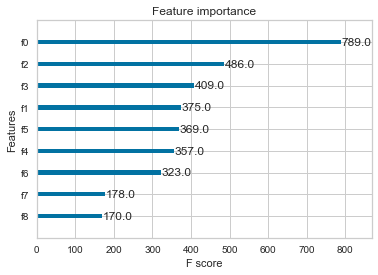

In [42]:
fig, ax = plt.subplots(figsize=(6,4))
xgb.plot_importance(xgr,ax=ax)

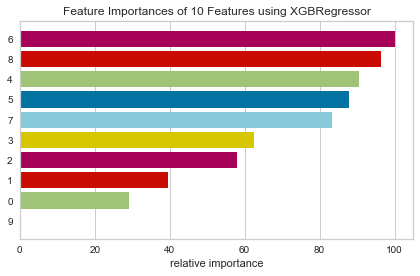

<AxesSubplot:title={'center':'Feature Importances of 10 Features using XGBRegressor'}, xlabel='relative importance'>

In [43]:
fig, ax = plt.subplots(figsize=(6,4))
fi_viz = FeatureImportances(xgr)
fi_viz.fit(lrX_train, lry_train)
fi_viz.poof()

<AxesSubplot:>

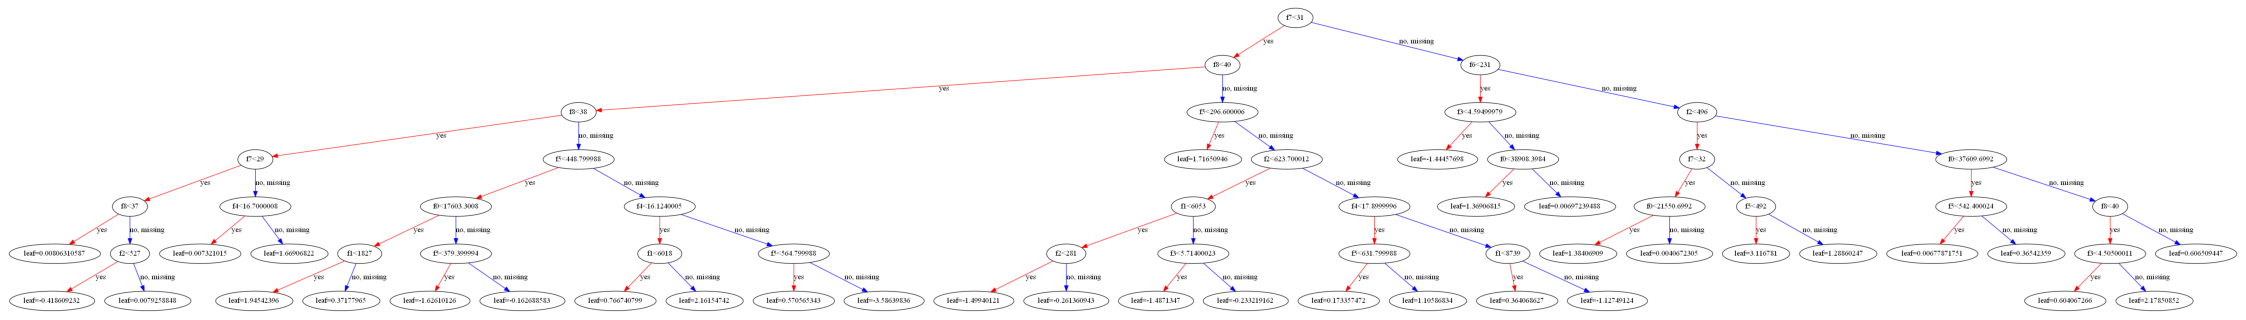

In [44]:
fig, ax = plt.subplots(figsize=(40,20))
xgb.plot_tree(xgr, ax=ax, num_trees=0)

### Métricas e avaliação de regressao

In [45]:
rfr.score(lrX_test, lry_test)

0.025178963971857038

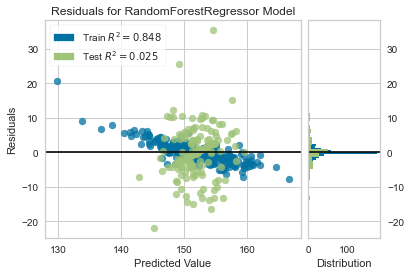

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [46]:
# grafico de resíduos
fig, ax = plt.subplots(figsize=(6,4))

rpv = ResidualsPlot(rfr)
rpv.fit(lrX_train, lry_train)
rpv.score(lrX_test, lry_test)
rpv.poof()


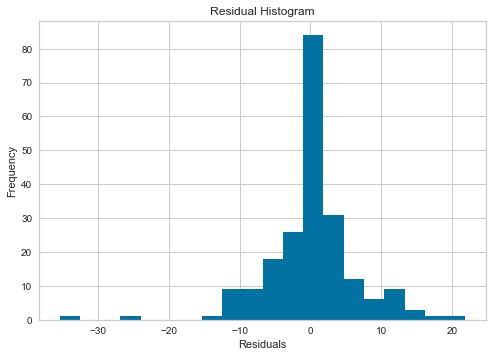

In [47]:
import statsmodels.stats.api as sms
resids = lry_test - rfr.predict(lrX_test)
plt.hist(resids, bins=20)
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

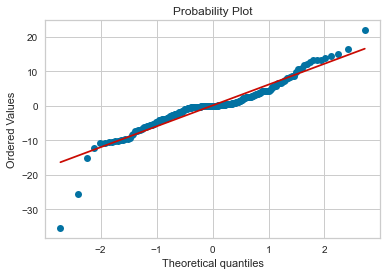

In [48]:
from scipy import stats
fig, ax = plt.subplots(figsize=(6,4))
_ = stats.probplot(resids, plot=ax)

In [49]:
stats.kstest(resids, cdf="norm")

KstestResult(statistic=0.27785916921558584, pvalue=5.794262792521405e-15, statistic_location=2.3310000000001594, statistic_sign=-1)

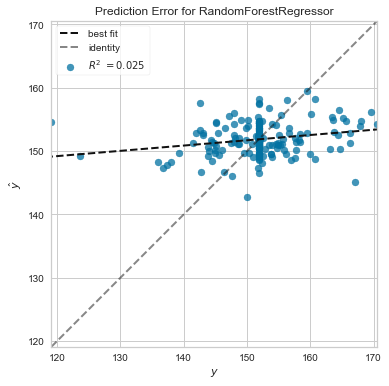

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [50]:
from yellowbrick.regressor import (PredictionError,)
fig, ax = plt.subplots(figsize=(6,6))
pev = PredictionError(rfr)
pev.fit(lrX_train, lry_train)
pev.score(lrX_test, lry_test)
pev.poof()

In [51]:
sample_idx = 5
xgr.predict(lr_X[[sample_idx]])

array([148.26726], dtype=float32)

In [52]:
import shap
shap.initjs()
exp = shap.TreeExplainer(xgr)
vals = exp.shap_values(lr_X)

shap.force_plot(
    exp.expected_value,
    vals[sample_idx],
    lr_X[sample_idx]
)

In [53]:
shap.force_plot(
    exp.expected_value, vals, lr_X
)

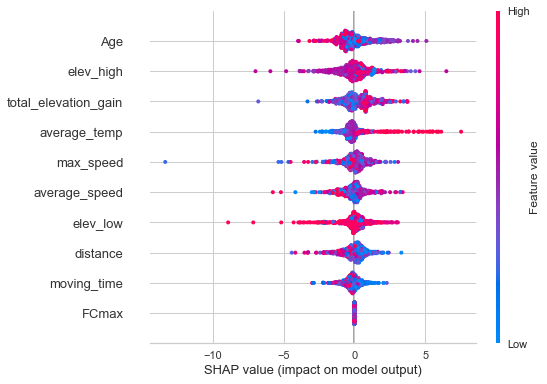

In [54]:
fig, ax = plt.subplots(figsize=(6,4))
shap.summary_plot(vals, lr_X,feature_names=df_lrstravatrain.columns)


## PCA
Redução da dimensionalidade

In [55]:
pca = PCA(random_state=42)
X_pca = pca.fit_transform(
    StandardScaler().fit_transform(lr_X)
)
pca.explained_variance_ratio_


array([3.07871508e-01, 2.57640669e-01, 1.34093641e-01, 1.11493138e-01,
       9.98829362e-02, 4.48111001e-02, 2.48566220e-02, 1.66343847e-02,
       2.71600088e-03, 3.17390927e-33])

[Text(0.5, 0, 'Componente'),
 Text(0, 0.5, 'Percente of explained variance'),
 Text(0.5, 1.0, 'Scree ploto'),
 (0.0, 1.0)]

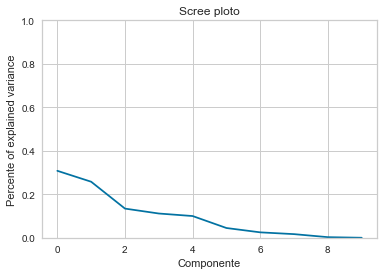

In [56]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(pca.explained_variance_ratio_)
ax.set(
    xlabel="Componente",
    ylabel = "Percente of explained variance",
    title="Scree ploto",
    ylim=(0,1),
)

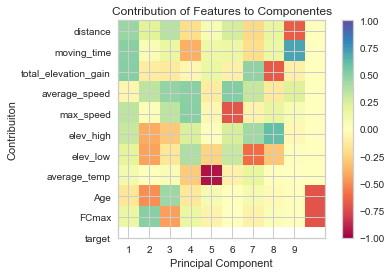

In [57]:
fig, ax = plt.subplots(figsize=(6,4))
plt.imshow(
    pca.components_.T,
    cmap="Spectral",
    vmin=-1,
    vmax=1,
)
plt.yticks(range(len(df_lrstravatrain.columns)), df_lrstravatrain.columns)
plt.xticks(range(9), range(1,10))
plt.xlabel("Principal Component")
plt.ylabel("Contribuiton")
plt.title(
    "Contribution of Features to Componentes"
)
plt.colorbar()

# Avaliação do Modelo

In [148]:
# Inicializar e treinar o modelo de regressão linear
model = LinearRegression()
model.fit(lrX_train, lry_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(lrX_test)

# Avaliar o modelo usando a métrica de erro médio quadrático
mse = mean_squared_error(lry_test, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 40.027993851495495


In [149]:
df_entrada = df.loc[(df['sport_type'] == "Ride") & (df['distance'] >= 10000) & (df['average_heartrate'].isna()),['distance','moving_time','total_elevation_gain','start_date','average_speed','max_speed','average_heartrate','max_heartrate', 'elev_high', 'elev_low','average_temp']]
df_entrada['start_date'] = pd.to_datetime(df_entrada['start_date'])
# funcao para calcular a idade no periodo da atividade
def calculate_age(birthdate_2):
    current_date = datetime(1980,11,18)
    age = birthdate_2.year - current_date.year - ((current_date.month, current_date.day) < (birthdate_2.month, birthdate_2.day))
    return age

# criando a nova coluna com o calculo da idade no periodo da atividade
df_entrada['Age'] = df_entrada['start_date'].apply(calculate_age)

# função para calcular o Frequencia Cardiaca Maxima (FC max)
def calc_fcmax(fcmax):
    fc_max = 220 - fcmax
    return fc_max

# criando a nova coluna com o calculo do FC Max com base na coluna idade
df_entrada['FCmax'] = df_entrada['Age'].apply(calc_fcmax)

df_entrada = df_entrada.loc[:,['distance','moving_time','total_elevation_gain','average_speed','max_speed','elev_high', 'elev_low','average_temp', 'Age', 'FCmax']]

df_entrada = df_entrada.dropna()


df_entrada.head()


,distance,moving_time,total_elevation_gain,average_speed,max_speed,elev_high,elev_low,average_temp,Age,FCmax
62,18394.9,5827,561.0,3.157,9.772,473.4,205.2,28.0,43,177
63,21962.0,5366,563.0,4.093,12.454,470.4,189.4,21.0,43,177
64,32064.5,8182,564.0,3.919,11.872,505.0,258.0,24.0,43,177
65,17992.0,6091,514.0,2.954,10.422,538.6,211.8,27.0,43,177
67,17715.4,6043,502.0,2.932,11.298,483.6,225.8,29.0,43,177


### Simulando a aplicação do modelo em dados não vistos

In [150]:
array_entrada = df_entrada.values
X_entrada = array_entrada[:,0:10].astype(float)

#Padronizada dados entrada
rescaladeEntradaX = scaler.transform(X_entrada)
print(rescaladeEntradaX)

[[-0.92484073 -0.3072683   0.02023376 ...  0.70365898  1.77320259
  -1.77320259]
 [-0.73986662 -0.44618509  0.02643732 ... -1.38676436  1.77320259
  -1.77320259]
 [-0.21599544  0.40238251  0.02953909 ... -0.49086864  1.77320259
  -1.77320259]
 ...
 [ 2.22888196  2.03352469 -1.4779248  ...  1.00229089 -1.50448526
   1.50448526]
 [ 0.59318525  0.31740521 -1.54616391 ... -0.19223673 -1.50448526
   1.50448526]
 [-0.41892714  1.1810397   1.60834387 ... -0.78950054 -1.50448526
   1.50448526]]


In [151]:
print(X_entrada)

[[1.83949e+04 5.82700e+03 5.61000e+02 ... 2.80000e+01 4.30000e+01
  1.77000e+02]
 [2.19620e+04 5.36600e+03 5.63000e+02 ... 2.10000e+01 4.30000e+01
  1.77000e+02]
 [3.20645e+04 8.18200e+03 5.64000e+02 ... 2.40000e+01 4.30000e+01
  1.77000e+02]
 ...
 [7.92123e+04 1.35950e+04 7.80000e+01 ... 2.90000e+01 3.50000e+01
  1.85000e+02]
 [4.76690e+04 7.90000e+03 5.60000e+01 ... 2.50000e+01 3.50000e+01
  1.85000e+02]
 [2.81511e+04 1.07660e+04 1.07300e+03 ... 2.30000e+01 3.50000e+01
  1.85000e+02]]


In [152]:
saidas = model.predict(rescaladeEntradaX)
print(saidas)

[129.03277643 128.8011946  128.97399055 128.85271342 128.96496533
 128.99207449 129.2683176  129.89958394 130.31396744 129.6748331
 129.63205353 128.87075361 128.88036254 129.32375043 128.8823451
 128.88595901 129.06093263 129.49058233 129.19917711 129.03741414
 128.8354411  128.92828862 129.59331922 129.60253725 129.64419797
 129.09557816 129.58640519 129.42569287 129.64448138 129.95480232
 129.7499396  129.66998931 129.9303354  129.9262591  129.80447812
 129.49686277 129.72021068 130.02219211 129.42419936 129.65965903
 129.12188546 129.43258301 129.74558315 129.20888722 129.49231719
 130.13867659 130.10311306 129.06278774 129.52896948 130.12069604
 129.60540015 129.88427343 129.8843063  130.50161024 130.23857184
 130.08291053 129.21943919 129.86928014 129.12375112 129.87016318
 129.17571492 128.47490281 129.70252319 128.84698987 129.28085315
 129.56683923 130.03457169 130.44817056 130.43433975 129.16499686
 130.33960497 129.59267987 130.16094499 130.99268387 130.5951426
 131.04136034

In [153]:
df_entrada['saida'] = saidas

df_entrada.head()

,distance,moving_time,total_elevation_gain,average_speed,max_speed,elev_high,elev_low,average_temp,Age,FCmax,saida
62,18394.9,5827,561.0,3.157,9.772,473.4,205.2,28.0,43,177,129.032776
63,21962.0,5366,563.0,4.093,12.454,470.4,189.4,21.0,43,177,128.801195
64,32064.5,8182,564.0,3.919,11.872,505.0,258.0,24.0,43,177,128.973991
65,17992.0,6091,514.0,2.954,10.422,538.6,211.8,27.0,43,177,128.852713
67,17715.4,6043,502.0,2.932,11.298,483.6,225.8,29.0,43,177,128.964965


Mean Squared Error (MSE): 526.4245189364459
R-squared (R2): -11.341851454426571


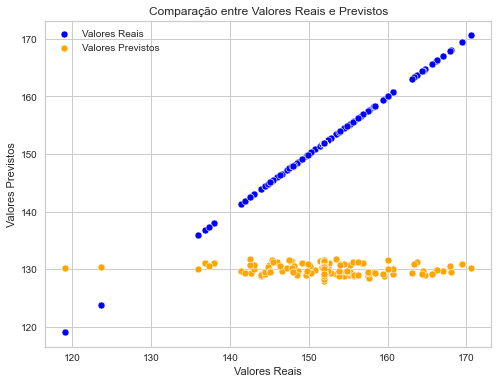

In [156]:
min_length = min(len(lry_test), len(saidas))
y_test = lry_test[:min_length]
y_pred = saidas[:min_length]

# Calcular métricas de desempenho
mse = mean_squared_error(y_test, saidas)
r2 = r2_score(y_test, saidas)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Visualizar a relação entre os valores previstos e reais
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=y_test, y=saidas)
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Valores Reais')
sns.scatterplot(x=y_test, y=saidas, color='orange', label='Valores Previstos')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação entre Valores Reais e Previstos")
plt.show()

Comparando o teste com dados não visto usando XGboost

In [163]:
xgr_saidas = xgr.predict(X_entrada)
print(xgr_saidas)

[151.90817 151.89262 151.84052 149.41066 151.89857 151.9044  152.85793
 151.91609 145.55013 151.88188 151.9648  151.89241 151.76111 148.76346
 151.9082  152.71945 151.91876 150.6197  151.8591  151.80801 151.58298
 150.29132 151.929   153.87086 153.79572 151.90735 157.66275 151.97469
 151.91757 149.22018 147.35674 151.90683 153.60294 151.87616 150.28522
 151.87602 151.88528 152.35353 157.88289 151.89697 148.823   151.91862
 151.8411  151.90912 151.91061 140.55576 151.89255 151.86673 151.89742
 150.62117 151.9012  151.92546 159.26509 151.85732 151.86433 158.8154
 152.72147 152.12881 151.92715 151.89919 151.9162  152.73792 151.79176
 150.23145 151.9121  151.88766 149.43057 151.89993 151.94496 151.91675
 151.92436 155.00952 151.91762 151.90442 151.85388 151.8934  151.2606
 151.79942 151.8948  151.90611 151.89766 151.91313 151.88959 151.82507
 151.94768 151.8957  152.2453  151.90085 152.21657 151.88335 153.04398
 156.50641 151.8917  155.48299 151.93958 151.61674 151.90521 152.53366
 151.912

Mean Squared Error (MSE): 48.27997923362553
R-squared (R2): -0.13190839425194656


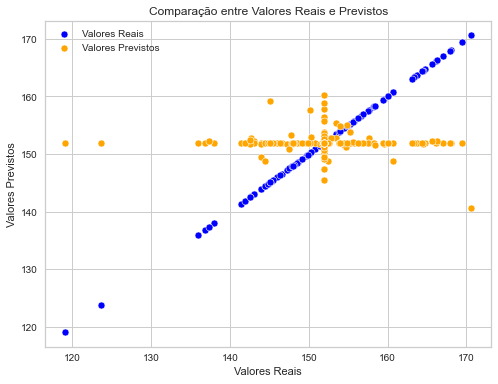

In [165]:
# Calcular métricas de desempenho
mse = mean_squared_error(y_test, xgr_saidas)
r2 = r2_score(y_test, xgr_saidas)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Visualizar a relação entre os valores previstos e reais
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=y_test, y=saidas)
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Valores Reais')
sns.scatterplot(x=y_test, y=xgr_saidas, color='orange', label='Valores Previstos')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação entre Valores Reais e Previstos")
plt.show()

## Lasso

Mean Squared Error (MSE): 39.356128158877034
R-squared (R2): 0.037781795423613374


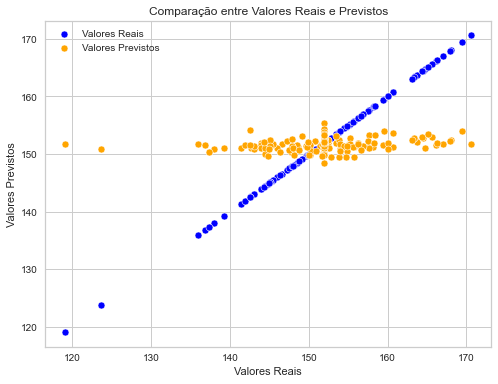

In [171]:
# Treinar o modelo Lasso
lasso_model = Lasso(alpha=0.1)  # Escolha do valor de alpha
lasso_model.fit(lrX_train, lry_train)

# Fazer previsões
lasso_pred = lasso_model.predict(lrX_test)


# Calcular métricas de desempenho
mse = mean_squared_error(lry_test, lasso_pred)
r2 = r2_score(lry_test, lasso_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Visualizar a relação entre os valores previstos e reais
plt.figure(figsize=(8, 6))
#sns.scatterplot(x=y_test, y=saidas)
sns.scatterplot(x=lry_test, y=lry_test, color='blue', label='Valores Reais')
sns.scatterplot(x=lry_test, y=lasso_pred, color='orange', label='Valores Previstos')
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Comparação entre Valores Reais e Previstos")
plt.show()

Treinar modelos de machine learning para um problema de classificação ou regressão: Você deverá treinar modelos clássicos de machine learning, iniciando na carga e preparação dos dados, incluindo a separação entre treino e teste, a seleção de atributos, transformação de dados, modelagem, otimização de hiperparâmetros, até a avaliação e comparação de resultados dos modelos treinados. É recomendado o uso de cross-validation e a criação de pipelines, conforme apresentado no material do curso.

Treinar modelos de Deep Learning para um problema de visão computacional ou processamento de linguagem natural: Você deverá treinar modelos baseados em Deep Learning para resolver um problema de visão computacional ou processamento de linguagem natural, iniciando na carga e preparação dos dados, incluindo a separação entre treino e teste, modelagem, otimização de hiperparâmetros, até a avaliação e comparação de resultados dos modelos treinados.